In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('figures.mplstyle')

In [2]:
from pymatgen.io.vasp import Poscar
import pandas as pd
from polyhedral_analysis.configuration import Configuration
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe
from polyhedral_analysis.octahedral_analysis import opposite_vertex_pairs
from polyhedral_analysis.utils import flatten
from collections import Counter
from scipy.stats import gaussian_kde
import numpy as np
import os

In [3]:
recipe = PolyhedraRecipe( method='distance cutoff', 
                          coordination_cutoff=3.0, 
                          central_atoms='Ti',
                          vertex_atoms=['O','F'] )

In [4]:
# load all `bsym` generated DFT-optimised poscars

In [5]:
class Config():
    
    def __init__(self, structure, config_id, energy):
        self.structure = structure
        self.config_id = config_id
        self.energy = energy
        self.config = Configuration( structure=structure, recipes=[recipe] )
        
    def non_f4o2(self):
        count = 0
        for p in self.config.polyhedra:
            coord_count = Counter([v.label for v in p.vertices])
            if coord_count['F'] != 4:
                count += 1
        return count
    
    def collinear_oxygen(self):
        count = 0
        for p in self.config.polyhedra:
            vertex_pairs = opposite_vertex_pairs( p, check=False )
            for vp in vertex_pairs:
                if set([vp[0].label, vp[1].label]) == {'O'}:
                    count += 1
        return count
    
    def bond_lengths(self):
        distances = { 'O': [], 'F': [] }
        for p in self.config.polyhedra:
            for d, l in p.vertex_distances_and_labels():
                distances[l].append(d)
        return distances

In [6]:
energies = pd.read_csv('../cluster_predictions/energies.out', delim_whitespace=True, names=['config_id', 'energy', 'dft_energy'])
energies.sort_values('config_id', inplace=True, )

In [7]:
configs = []
for i in range(2664):
    filename = f'../2x2x2_vasp_calculations/config_{i:04d}/POSCAR'.format(i)
    if os.path.isfile( filename ):
        structure = Poscar.from_file(filename).structure
        energy = energies.iloc[i].energy
        configs.append(Config(structure, i, energy))
print(f'Read {len(configs)} POSCAR files')

Read 65 POSCAR files


For each DFT optimised 2&times;2&times;2 TiOF2 configuration, calculate the range of Ti–F and Ti–O distances and plot this range, plus the means of both sets of distances, versus the cluster-expansion–predicted energy.

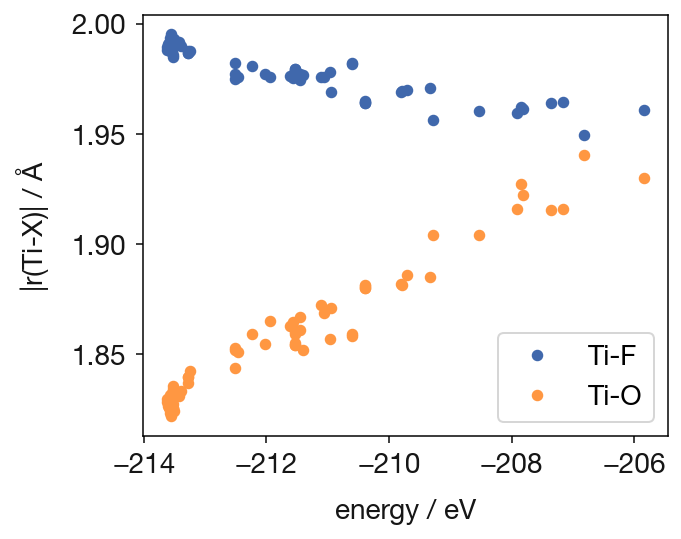

In [8]:
color1 = "#4068ac"
color2 = "#ff9742"
# color3 = "#32a852"

fig = plt.figure(figsize=(5,4))
f_bond_data = []
o_bond_data = []
for c in configs:
    bond_lengths = c.bond_lengths()
    mean_tif_distance = np.mean(bond_lengths['F'])
    mean_tio_distance = np.mean(bond_lengths['O'])
    tif_lower = mean_tif_distance - min(bond_lengths['F'])
    tif_upper = max(bond_lengths['F']) - mean_tif_distance
    tio_lower = mean_tio_distance - min(bond_lengths['O'])
    tio_upper = max(bond_lengths['O']) - mean_tio_distance
    plt.plot(c.energy, mean_tif_distance, 'o', c=color1)
    plt.plot(c.energy, mean_tio_distance, 'o', c=color2) 

plt.plot(c.energy, mean_tif_distance, 'o', label=r'Ti-F', color=color1)
plt.plot(c.energy, mean_tio_distance, 'o', label=r'Ti-O', color=color2)
plt.legend()
plt.xlabel('energy / eV')
plt.ylabel(r'|$r$(Ti-$X$)| / Å')
plt.tight_layout()
plt.savefig('TiOF2_Ti-X_distances.pdf')
plt.show()